# Chi Square Tester for NRWC Workshop

In [23]:
# Import necessary functions
import pandas as pd 
import numpy as np 
import math
import helper_functions as hf
import matplotlib.pyplot as plt
from scipy import stats
from scipy.special import gammaincc  # for calculating p-value from chi-square statistic

# Use autoreload to automatically reload changes from the Python file
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Input number of participants here 

In [2]:
# Define number of participants 
# This can also be used later for power calculations 
participants = hf.get_user_input()
print(f"The number of participants is: {participants}")

Please enter a number:  5


The number of participants is: 5


## Input results from quiz here

In [3]:
# Define columns and create an empty DataFrame
columns = ['A', 'B', 'C', 'D', 'E', 'F']  # Answers for each question
index = [f'Q{i+1}' for i in range(6)]  # Questions Q1 to Q6
df = pd.DataFrame(columns=columns, index=index)
#hf.input_data(index, columns)
df.loc['Q1'] = [0, 0, 1, 1, 0, 2]  # Replace with actual values for Q1 etc
df.loc['Q2'] = [0, 0, 1, 1, 0, 2]  
df.loc['Q3'] = [0, 0, 1, 1, 0, 2]  
df.loc['Q4'] = [0, 0, 1, 1, 0, 2]  
df.loc['Q5'] = [0, 0, 1, 1, 0, 2]  
df.loc['Q6'] = [0, 0, 1, 1, 0, 2]  

df

,A,B,C,D,E,F
Q1,0,0,1,1,0,2
Q2,0,0,1,1,0,2
Q3,0,0,1,1,0,2
Q4,0,0,1,1,0,2
Q5,0,0,1,1,0,2
Q6,0,0,1,1,0,2


In [4]:
# Print row 1 
df.loc['Q1'] 

A    0
B    0
C    1
D    1
E    0
F    2
Name: Q1, dtype: object

In [5]:
# For testing, generate random numbers if there are n participants 

# Set random seed for reproducibility
np.random.seed(0)

# Define the indices and columns
row_indices = [f'Q{i}' for i in range(1, 7)]
columns = ['A', 'B', 'C', 'D', 'E', 'F']

# Initialize an empty DataFrame
df = pd.DataFrame(index=row_indices, columns=columns)

# Fill the DataFrame with random integers such that the sum of each row equals 5
for row in row_indices:
    # Generate random integers that sum to n participants
    values = np.random.multinomial(participants, [1/6]*6)
    # Assign to the DataFrame
    df.loc[row] = values

# Display the DataFrame
print(df)

# Do we need to divide by 10 get percentages? 

    A  B  C  D  E  F
Q1  1  1  1  1  0  1
Q2  1  1  2  1  0  0
Q3  0  2  1  1  1  0
Q4  0  0  0  3  2  0
Q5  2  2  1  0  0  0
Q6  1  1  0  1  0  2


In [17]:
df

,A,B,C,D,E,F
Q1,1,1,1,1,0,1
Q2,1,1,2,1,0,0
Q3,0,2,1,1,1,0
Q4,0,0,0,3,2,0
Q5,2,2,1,0,0,0
Q6,1,1,0,1,0,2


## Chi-Square Goodness of Fit Test 
Tests whether the observed frequencies of a single categorical variable match expected frequencies under a specific hypothesis.

Hypothesis:
- Null Hypothesis (H₀): The observed distribution matches the expected distribution.
- Alternative Hypothesis (H₁): The observed distribution does not match the expected distribution.

The Chi-Square Goodness of Fit Test compares the observed distribution of responses to a uniform distribution, assuming that each answer choice (A-F) has an equal probability of being selected if participants are choosing randomly.

### Input question data here

In [16]:
#Observed counts for each option A-F in question Q1
observed_counts = df.loc['Q1']
observed_counts

A    1
B    1
C    1
D    1
E    0
F    1
Name: Q1, dtype: object

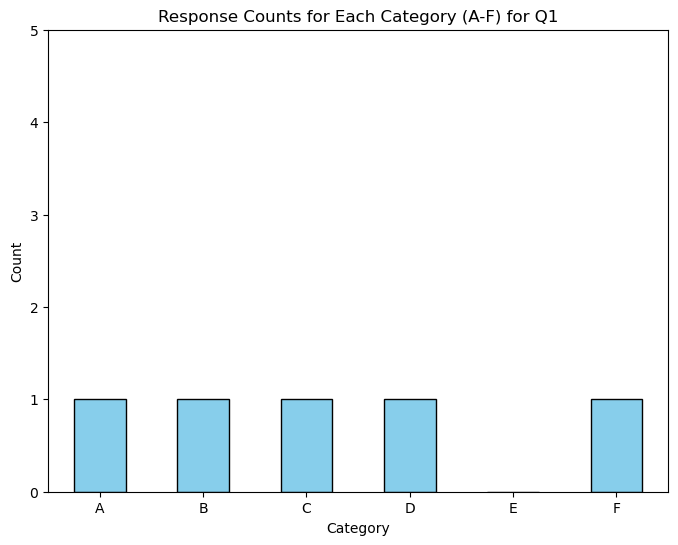

In [25]:
# Plot data 
# Convert the Series to a dictionary
data = observed_counts.to_dict()

# Plotting the data
plt.figure(figsize=(8, 6))
pd.Series(data).plot(kind='bar', color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Response Counts for Each Category (A-F) for Q1')
plt.xticks(rotation=0)
# Set y-axis limit to the total number of replies
plt.ylim(0, total_responses)  # Set the y-axis limits
plt.show()

### Manual calculation

In [13]:
# Calculate the total number of responses
total_responses = sum(observed_counts)

# Calculate the expected counts assuming each option is equally likely
expected_count = total_responses / 6
expected_counts = [expected_count] * 6

# Calculate the Chi-Square statistic by hand
chi_square_stat = sum(
    ((observed - expected) ** 2) / expected
    for observed, expected in zip(observed_counts, expected_counts)
)

# Print the calculated Chi-Square statistic
print("Chi-Square Statistic (calculated manually):", chi_square_stat)

# Degrees of freedom for this test
deg_freedom = len(observed_counts) - 1  # Here, df = 6 - 1 = 5

# To determine the significance level, we typically need a p-value.
# To fully implement this, we’d need to calculate or look up the critical value in a Chi-Square table.
# Example:
# For df=5 and significance level 0.05, the critical value is approximately 11.07
# So, we can interpret by comparing:

critical_value_95 = 11.07

# Calculate the p-value using the Chi-Square survival function
p_value = gammaincc(deg_freedom / 2, chi_square_stat / 2)

#if chi_square_stat > critical_value_95:
if p_value < 0.05:
    print("The result is statistically significant at the 0.05 level.")
    print("The observed distribution of responses is significantly different from random guessing.")
else:
    print("The result is not statistically significant at the 0.05 level.")
    print("The observed distribution of responses is consistent with random guessing.")


Chi-Square Statistic (calculated manually): 1.0
The result is not statistically significant at the 0.05 level.
The observed distribution of responses is consistent with random guessing.


### Using scipy.stats package

In [14]:
# Calculate the total number of responses for Q1
total_responses = sum(observed_counts)

# Expected counts assuming equal probability for each option (random guessing)
expected_count = total_responses / 6
expected_counts = [expected_count] * 6

# Perform the Chi-Square Goodness of Fit test
chi2_stat, p_value = stats.chisquare(f_obs=observed_counts, f_exp=expected_counts)

# Output the results
print("Total number of responses:", total_responses)
print("Chi-Square Statistic:", chi2_stat) # How much the observed counts differ from the expected counts. Higher values indicate larger deviations.
print("p-value:", p_value) # A low p-valu, it suggests that the distribution of responses in Q1 is not likely to be due to random guessing, and some options may be selected more often than expected by chance.

# Interpretation of results
if p_value < 0.05:
    print(f"The p-value is {p_value:.4f}. This is less than the significance level of 0.05.")
    print("We reject the null hypothesis, suggesting that the observed distribution of responses for question Q1")
    print("is significantly different from what would be expected by random guessing. Some answer options may be chosen more often.")
else:
    print(f"The p-value is {p_value:.4f}. This is greater than the significance level of 0.05.")
    print("We do not reject the null hypothesis, indicating that the observed distribution of responses for question Q1")
    print("is not significantly different from random guessing. The responses appear consistent with chance.")

Total number of responses: 5
Chi-Square Statistic: 1.0
p-value: 0.9625657732472964
The p-value is 0.9626. This is greater than the significance level of 0.05.
We do not reject the null hypothesis, indicating that the observed distribution of responses for question Q1
is not significantly different from random guessing. The responses appear consistent with chance.


## Crochan Q test 

Conclusion: 
Use Crochan Q test. McNemar test for post hoc tests. Please note that although the data is coded as right or wrong, the ratio is not 50%. Correct option is only 1/6. 

If you want to directly test whether the observed proportion of correct answers differs from random guessing across all questions, you might also consider a binomial test or chi-square goodness-of-fit test for each question individually. This would check whether the proportion of correct answers per question differs significantly from 16.67%, which represents random guessing. 

In short, the 1:5 ratio of correct to incorrect options doesn’t impact the binary setup of Cochran’s Q test but does affect the baseline expectation for correct answers if guessing is assumed. You can use Cochran’s Q to explore consistency across questions, and if needed, conduct additional analyses to examine how actual correctness rates align with guessing probability.
